# Project 3: GDP per Capita and Life Expectancy

by Michel Wermelinger, 27 August 2015, and Benjamin Woodling, 01 December 2015.

This is the project notebook for Week 3 of The Open University's [_Learn to code for Data Analysis_](http://futurelearn.com/courses/learn-to-code) course.

Richer countries can afford to invest more on healthcare, on work and road safety, and other measures that reduce mortality. On the other hand, richer countries may have less healthy lifestyles. Is there any relation between the wealth of a country and the life expectancy of its inhabitants?

The following analysis checks whether there is any correlation between the total gross domestic product (GDP) of a country in 2013 and the life expectancy of people born in that country in 2013.

## Getting the data

Two datasets of the World Bank are considered. One dataset, available at <http://data.worldbank.org/indicator/NY.GDP.MKTP.CD>, lists the GDP of the world's countries in current US dollars, for various years. The use of a common currency allows to compare GDP values across countries. The other dataset, available at <http://data.worldbank.org/indicator/SP.DYN.LE00.IN>, lists the life expectancy of the world's countries. 

The datasets are downloaded directly, using the unique indicator name given in the URL.

In [198]:
from pandas import *
from pandas.io.wb import download

YEAR = 2013
GDP_INDICATOR = 'NY.GDP.MKTP.CD'
gdp = download(indicator=GDP_INDICATOR, country='all', start=YEAR, end=YEAR)
LIFE_INDICATOR = 'SP.DYN.LE00.IN'
life = download(indicator=LIFE_INDICATOR, country='all', start=YEAR, end=YEAR)

## Cleaning the data

Inspecting the data with `head()` and `tail()` shows that:

1. country names are the row indices, not column values;
- the first 34 rows are aggregated data, for the Arab World, the Caribbean small states, and other country groups used by the World Bank;
- GDP and life expectancy values are missing for some countries.

The data is therefore cleaned by:
1. transforming the dataframe index into columns and creating a new index 0, 1, 2, etc.;
- removing the first 34 rows;
- removing rows with unavailable values.

In [199]:
gdp = gdp.reset_index()[34:].dropna()
life = life.reset_index()[34:].dropna()

## Transforming the data

The World Bank reports GDP in US dollars and cents. To make the data easier to read, the GDP is converted to millions of British pounds (the author's local currency) with the following auxiliary functions, using the average 2013 dollar-to-pound conversion rate provided by <http://www.ukforex.co.uk/forex-tools/historical-rate-tools/yearly-average-rates>. 

In [200]:
def roundToMillions (value):
    return round(value / 1000000)

def usdToGBP (usd):
    return usd / 1.564768

GDP = 'GDP (£m)'
gdp[GDP] = gdp[GDP_INDICATOR].apply(usdToGBP).apply(roundToMillions)
gdp.head()

,country,year,NY.GDP.MKTP.CD,GDP (£m)
34,Afghanistan,2013,2.031088e+10,12980
35,Albania,2013,1.291667e+10,8255
36,Algeria,2013,2.101834e+11,134322
38,Andorra,2013,3.249101e+09,2076
39,Angola,2013,1.241632e+11,79349


The unnecessary columns can be dropped.

In [201]:
COUNTRY = 'country'
headings = [COUNTRY, GDP]
gdp = gdp[headings]
gdp.head()

,country,GDP (£m)
34,Afghanistan,12980
35,Albania,8255
36,Algeria,134322
38,Andorra,2076
39,Angola,79349


The World Bank reports the life expectancy with several decimal places. After rounding, the original column is discarded.

In [202]:
LIFE = 'Life expectancy (years)'
life[LIFE] = life[LIFE_INDICATOR].apply(round)
headings = [COUNTRY, LIFE]
life = life[headings]
life.head()

,country,Life expectancy (years)
34,Afghanistan,61
35,Albania,78
36,Algeria,71
39,Angola,52
40,Antigua and Barbuda,76


## Combining the data

The tables are combined through an inner join on the common 'country' column. 

In [203]:
gdpVsLife = merge(gdp, life, on=COUNTRY, how='inner')
gdpVsLife.head()

,country,GDP (£m),Life expectancy (years)
0,Afghanistan,12980,61
1,Albania,8255,78
2,Algeria,134322,71
3,Angola,79349,52
4,Antigua and Barbuda,767,76


## Calculating the correlation

To measure if the life expectancy and the GDP grow together, the Spearman rank correlation coefficient is used. It is a number from -1 (perfect inverse rank correlation: if one indicator increases, the other decreases) to 1 (perfect direct rank correlation: if one indicator increases, so does the other), with 0 meaning there is no rank correlation. A perfect correlation doesn't imply any cause-effect relation between the two indicators. A p-value below 0.05 means the correlation is statistically significant.

In [204]:
from scipy.stats import spearmanr

gdpColumn = gdpVsLife[GDP]
lifeColumn = gdpVsLife[LIFE]
(correlation, pValue) = spearmanr(gdpColumn, lifeColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.492478668762
It is statistically significant.


The value shows a direct correlation, i.e. richer countries tend to have longer life expectancy, but it is not very strong.

## Showing the data

Measures of correlation can be misleading, so it is best to see the overall picture with a scatterplot. The GDP axis uses a logarithmic scale to better display the vast range of GDP values, from a few million to several billion (million of million) pounds.

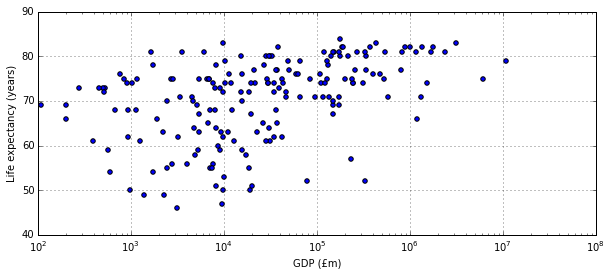

In [205]:
%matplotlib inline
gdpVsLife.plot(x=GDP, y=LIFE, kind='scatter', grid=True, logx=True, figsize=(10, 4))

The plot shows there is no clear correlation: there are rich countries with low life expectancy, poor countries with high expectancy, and countries with around 10 thousand (10<sup>4</sup>) million pounds GDP have almost the full range of values, from below 50 to over 80 years. Towards the lower and higher end of GDP, the variation diminishes. Above 40 thousand million pounds of GDP (3rd tick mark to the right of 10<sup>4</sup>), most countries have an expectancy of 70 years or more, whilst below that threshold most countries' life expectancy is below 70 years. 

Comparing the 10 richest countries and the 10 countries with the highest life expectancy shows that total GDP is a rather crude measure of life expectancy. The population size should be taken into account for a more precise definition of what 'poor' and 'rich' means. Looking at the countries below, the ten richest countries consume significantly large land areas and presumably high populations to boost the total GDP. The ten countries with the highest life expectancy are all except for Singapore (an oddity in the list) highly developed first world countries with large proportions of people working in financial, commercial and service industries. They are countries made up of a large proportion of relatively rich people. This suggests a strong correlation between an individual's wealth and high life expectancy. 

In [206]:
# the 10 countries with highest GDP
gdpVsLife.sort(GDP).tail(10)

,country,GDP (£m),Life expectancy (years)
76,India,1189826,66
139,Russian Federation,1328647,71
82,Italy,1365665,82
23,Brazil,1528722,74
176,United Kingdom,1711547,81
59,France,1795953,82
63,Germany,2383906,81
84,Japan,3143957,83
35,China,6065182,75
177,United States,10715999,79


In [207]:
# the 10 countries with longest life expectancy
gdpVsLife.sort(LIFE).tail(10)

,country,GDP (£m),Life expectancy (years)
59,France,1795953,82
100,Luxembourg,38428,82
148,Singapore,193157,82
161,Sweden,370359,82
7,Australia,997191,82
82,Italy,1365665,82
84,Japan,3143957,83
162,Switzerland,438042,83
75,Iceland,9838,83
73,"Hong Kong SAR, China",176220,84


## Two countries 
There are two countries in the right half of the plot (higher GDP) with life expectancy below 60 years.

In [208]:
gdpVsLife[(gdpVsLife[LIFE] < 60) & (gdpVsLife[GDP] > 100000)]

,country,GDP (£m),Life expectancy (years)
125,Nigeria,329100,52
152,South Africa,233937,57


What factors could explain their lower life expectancy compared to countries with similar GDP? These are African nations and probably two of the wealthiest African nations, more so in terms of total GDP. They may have very large populations and an unequal division of wealth. Access to good healthcare is notoriously bad for the majority of poor Africans. The continent is plagued by war, famine and diseases that have been wiped out in developed parts of the world. A country may have a high GDP but with a large population and high numbers of people living in poverty then the average life expectancy is likely to fall compared with countries of a similarly high GDP. All these factors are likely to apply to Nigeria and South Africa. 

## GDP per capita
GDP per capita calculates the GDP per person, i.e. GDP / Population. I have reasoned that this may give a fairer depiction of the correlation between wealth and life expectancy.


In [209]:
# Import the population data from the World Bank site. 
from pandas import *
from pandas.io.wb import download

YEAR = 2013
POP_INDICATOR = 'SP.POP.TOTL'
pop = download(indicator=POP_INDICATOR, country='all', start=YEAR, end=YEAR)
POP = "Population"
pop[POP] = pop[POP_INDICATOR]
pop = pop.reset_index()
headings = [COUNTRY, POP]
pop = pop[34:].dropna()[headings]

# Merge this data with the current table.
gdpVsLifeVsPop = merge(gdpVsLife, pop, on=COUNTRY, how='inner')

# Add GDP per capita column by calculating a country's GDP (£) divided by its population
gdpVsLifeVsPop[GDPPC] = (gdpVsLifeVsPop[GDP]*1000000/(gdpVsLifeVsPop[POP])).round(2)

In [210]:
# The ten poorest countries by per capita GDP (£)
gdpVsLifeVsPop.sort(GDPPC).head(10)

,country,GDP (£m),Life expectancy (years),Population,GDP per Capita (£)
104,Malawi,2482,55,16190126,153.30
27,Burundi,1735,54,10465959,165.78
32,Central African Republic,987,50,4710678,209.52
38,"Congo, Dem. Rep.",19182,50,72552861,264.39
124,Niger,4910,58,18358863,267.45
97,Liberia,1244,61,4293692,289.73
103,Madagascar,6783,65,22924557,295.88
61,"Gambia, The",570,59,1866878,305.32
55,Ethiopia,30372,64,94558374,321.20
68,Guinea,3983,56,11948726,333.34


In [211]:
# The ten richest countries by per capita GDP (£)
gdpVsLifeVsPop.sort(GDPPC).tail(10)

,country,GDP (£m),Life expectancy (years),Population,GDP per Capita (£)
148,Singapore,193157,82,5399200,35775.11
46,Denmark,214650,80,5614932,38228.42
161,Sweden,370359,82,9600379,38577.54
7,Australia,997191,82,23125868,43120.15
162,Switzerland,438042,83,8089346,54150.48
18,Bermuda,3562,81,65001,54799.16
101,"Macao SAR, China",32793,80,568056,57728.46
137,Qatar,129882,79,2101288,61810.66
126,Norway,333819,81,5079623,65717.28
100,Luxembourg,38428,82,543360,70722.91


In [212]:
# And import the World Bank data value itself in international dollars
YEAR = 2013
GPC_INDICATOR = 'NY.GDP.PCAP.PP.CD'
gpc = download(indicator=GPC_INDICATOR, country='all', start=YEAR, end=YEAR)
GPC = 'GDP Per Cap ($)'
gpc[GPC] = gpc[GPC_INDICATOR]
gpc = gpc.reset_index()
headings = [COUNTRY, GPC]
gpc = gpc[34:].dropna()[headings]

# Merge all data
twoPerCapVals = merge(gdpVsLifeVsPop, gpc, on=COUNTRY, how='inner')

In [213]:
# The ten richest countries by per capita - World Bank data (Int $)
twoPerCapVals.sort(GPC).head(10)

,country,GDP (£m),Life expectancy (years),Population,GDP per Capita (£),GDP Per Cap ($)
31,Central African Republic,987,50,4710678,209.52,591.287014
37,"Congo, Dem. Rep.",19182,50,72552861,264.39,695.696845
26,Burundi,1735,54,10465959,165.78,749.326722
102,Malawi,2482,55,16190126,153.30,790.025986
95,Liberia,1244,61,4293692,289.73,844.243544
121,Niger,4910,58,18358863,267.45,900.151134
115,Mozambique,9878,50,26467180,373.22,1073.354223
66,Guinea,3983,56,11948726,333.34,1231.714470
67,Guinea-Bissau,605,54,1757138,344.31,1364.652913
164,Togo,2773,56,6928719,400.22,1368.067380


In [214]:
# The ten richest countries by per capita - World Bank data (Int $)
twoPerCapVals.sort(GPC).tail(10)

,country,GDP (£m),Life expectancy (years),Population,GDP per Capita (£),GDP Per Cap ($)
71,"Hong Kong SAR, China",176220,84,7187500,24517.57,53366.705986
159,Switzerland,438042,83,8089346,54150.48,56939.670293
172,United Arab Emirates,257124,77,9039978,28442.99,63116.602422
123,Norway,333819,81,5079623,65717.28,65640.162655
23,Brunei Darussalam,10296,79,411499,25020.72,72871.436805
89,Kuwait,112366,74,3593689,31267.59,76886.097209
145,Singapore,193157,82,5399200,35775.11,80295.027795
98,Luxembourg,38428,82,543360,70722.91,91047.588883
134,Qatar,129882,79,2101288,61810.66,140296.067939
99,"Macao SAR, China",32793,80,568056,57728.46,140644.394985


## Calculating the correlation based on GDP per capita 

In [215]:
from scipy.stats import spearmanr

gpcColumn = twoPerCapVals[GPC]
lifeColumn = twoPerCapVals[LIFE]
(correlation, pValue) = spearmanr(gpcColumn, lifeColumn)
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.835314137588
It is statistically significant.


The value shows a direct correlation, i.e. richer countries tend to have longer life expectancy, and it is much stronger when based on GDP per capita than when based on total GDP.

## Showing the data based on GDP per capita 

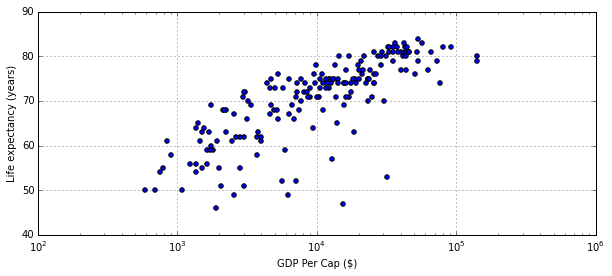

In [216]:
%matplotlib inline
twoPerCapVals.plot(x=GPC, y=LIFE, kind='scatter', grid=True, logx=True, figsize=(10, 4))

This plot shows a more marked trend than we saw before. A general linear slant (representing a clear positive correlation between GDP Per Capita and Life Expectancy) can be seen. While there remain some exceptions to this trend, generally as a nation state's GDP per person increases so does life expectancy.

## Conclusions

To sum up, there is some correlation between a country's wealth and the life expectancy of its inhabitants: there is often a wide variation of life expectancy for countries with similar GDP, countries with the lowest life expectancy are not the poorest countries, and countries with the highest expectancy are not the richest countries. Nevertheless there is some relationship, because the vast majority of countries with a life expectancy below 70 years is on the left half of the scatterplot.

Using the [NY.GDP.PCAP.PP.CD](http://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) indicator, GDP per capita in current 'international dollars', would make for a better like-for-like comparison between countries, because it would take population and purchasing power into account. Using more specific data, like expenditure on health, could also lead to a better analysis.


## Conclusions based on GDP per capita

Finally my calculations are in. GDP per capita in current 'international dollars' is a significantly better tool for highlighting the link between life expectancy and the wealth of a country. Life expectancy in the ten countries rated poorest on these terms ranged from 50 to 61. Every one of those countries is an African nation. While more geographically varied on the basis of GDP per capita, life expectancy in the ten richest countries ranged from 74 to 84 years of age. Stark extremes are highlighted here which suggest that those born in the richest countries in the world can, on average, expect to live a full quarter of a century longer than those born in the poorest nations.